<a href="https://colab.research.google.com/github/SaidattaGoparaju/PresentProject/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Conv1D, BatchNormalization,Dense, InputLayer, Flatten, Activation
from keras.models import Sequential
from sklearn import preprocessing

In [8]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/CMaps/

Mounted at /content/drive/
/content/drive/My Drive/CMaps


In [3]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '../Output/regression_model.h5'

In [10]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('/content/drive/MyDrive/CMaps/train_FD002.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])


In [11]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('/content/drive/MyDrive/CMaps/test_FD002.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('/content/drive/MyDrive/CMaps/RUL_FD002.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [12]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [13]:
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [15]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


train_df.to_csv('train_FD001.txt', encoding='utf-8',index = None)

In [16]:
######
# TEST
######
# MinMax normalization (from 0 to 1)

test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

   id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    9.9987    0.2502     100.0  489.05  605.03  1497.17  1304.99   
1   1      2   20.0026    0.7000     100.0  491.19  607.82  1481.20  1246.11   
2   1      3   35.0045    0.8400     100.0  449.44  556.00  1359.08  1128.36   
3   1      4   42.0066    0.8410     100.0  445.00  550.17  1349.69  1127.89   
4   1      5   24.9985    0.6213      60.0  462.54  536.72  1253.18  1050.69   

      s5  ...      s13      s14      s15   s16    s17     s18     s19    s20  \
0  10.52  ...  2388.18  8114.10   8.6476  0.03  369.0  2319.0  100.00  28.42   
1   9.35  ...  2388.12  8053.06   9.2405  0.02  364.0  2324.0  100.00  24.29   
2   5.48  ...  2387.75  8053.04   9.3472  0.02  333.0  2223.0  100.00  14.98   
3   3.91  ...  2387.72  8066.90   9.3961  0.02  332.0  2212.0  100.00  10.35   
4   7.05  ...  2028.05  7865.66  10.8682  0.02  305.0  1915.0   84.93  14.31   

       s21  cycle_norm  
0  17.1551   

In [17]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)


In [18]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.to_csv('test_FD001.txt', encoding='utf-8',index = None)

In [19]:
# pick a large window size of 50 cycles
sequence_length = 100

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


In [20]:
# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


In [22]:
# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

49


In [23]:
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())


In [24]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(27759, 100, 25)


In [25]:
# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [27]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(27759, 1)

In [28]:
##################################
# Modeling
##################################

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [37]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

cnn = Sequential()
cnn.add(InputLayer(input_shape=(sequence_length, nb_features)))
cnn.add(BatchNormalization(axis=-1))  #Scaling the data

cnn.add(Conv1D(filters=64,
               kernel_size=3,
               padding="valid",
               activation="relu",
               kernel_regularizer='l2'
               )
       )

In [38]:
# cnn.add(MaxPool1D(pool_size=2))
# cnn.add(BatchNormalization(axis=-1))
cnn.add(Conv1D(filters=64,
               kernel_size=3,
               padding="valid",
               activation="relu",
               kernel_regularizer='l2')
       )

cnn.add(Conv1D(filters=64,
               kernel_size=3,
               padding="valid",
               activation="relu",
               kernel_regularizer='l2')
       )

In [40]:
# cnn.add(BatchNormalization(axis=-1))
# cnn.add(MaxPool1D(pool_size=2))
# cnn.add(BatchNormalization(axis=-1))

cnn.add(Conv1D(filters=64,
               kernel_size=3,
               padding="valid",
               activation="relu",
               kernel_regularizer='l2')
       )

cnn.add(Flatten())
cnn.add(Dense(40))
cnn.add(Activation('relu'))
cnn.add(Dense(30))
cnn.add(Activation('relu'))
cnn.add(Dense(units=nb_out))
cnn.add(Activation("relu"))

In [41]:
# cnn.add(Dense(30))
# cnn.add(Activation('relu'))
# cnn.add(Dense(20))
# cnn.add(Activation('relu'))
# cnn.add(Dense(10))
# cnn.add(Activation('relu'))
# cnn.add(Dense(units=nb_out))
# cnn.add(Activation('relu'))
cnn.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[rmse,r2_keras])

print(cnn.summary())

history = cnn.fit(seq_array, label_array, epochs=100, batch_size=512, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 100, 25)          100       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 98, 64)            4864      
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 64)            12352     
                                                                 
 conv1d_11 (Conv1D)          (None, 94, 64)            12352     
                                                                 
 conv1d_12 (Conv1D)          (None, 92, 64)            12352     
                                                                 
 flatten_1 (Flatten)         (None, 5888)              0         
                                                      

In [42]:
# model = Sequential()
# model.add(LSTM(
#          input_shape=(sequence_length, nb_features),
#          units=100,
#          return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(
#           units=100,
#           return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=nb_out))
# model.add(Activation("linear"))
# model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
#
# print(model.summary())
#
#
#
# # fit the network
# history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#           )

# list all data in history
print(history.history.keys())



dict_keys(['loss', 'rmse', 'r2_keras', 'val_loss', 'val_rmse', 'val_r2_keras'])


In [43]:
# training metrics
scores = cnn.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = cnn.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

139/139 [==============================] - 7s 48ms/step - loss: 225.5704 - rmse: 11.1715 - r2_keras: 0.8454

MAE: 11.17149543762207

R^2: 0.8453773260116577
139/139 [==============================] - 7s 47ms/step


In [44]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

seq_array_test_last
(168, 100, 25)


In [45]:
# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)


(168, 1)
label_array_test_last
[[ 18.]
 [106.]
 [ 15.]
 [  6.]
 [ 90.]
 [ 11.]
 [  6.]
 [ 30.]
 [ 11.]
 [ 37.]
 [ 68.]
 [ 22.]
 [ 54.]
 [ 97.]
 [ 10.]
 [ 77.]
 [ 88.]
 [ 83.]
 [ 78.]
 [ 75.]
 [ 11.]
 [ 53.]
 [100.]
 [ 55.]
 [ 48.]
 [ 37.]
 [ 44.]
 [ 27.]
 [ 18.]
 [  6.]
 [ 15.]
 [112.]
 [ 13.]
 [ 13.]
 [ 53.]
 [ 52.]
 [103.]
 [ 26.]
 [ 73.]
 [ 39.]
 [ 39.]
 [ 14.]
 [ 11.]
 [ 86.]
 [ 56.]
 [115.]
 [ 17.]
 [104.]
 [ 78.]
 [ 86.]
 [ 98.]
 [ 36.]
 [ 52.]
 [ 91.]
 [ 15.]
 [ 17.]
 [ 47.]
 [ 21.]
 [ 79.]
 [  8.]
 [  9.]
 [ 73.]
 [ 97.]
 [ 49.]
 [ 31.]
 [ 97.]
 [  9.]
 [ 14.]
 [  8.]
 [  8.]
 [106.]
 [ 61.]
 [168.]
 [ 35.]
 [ 80.]
 [  9.]
 [ 50.]
 [ 78.]
 [ 91.]
 [  7.]
 [106.]
 [ 15.]
 [  7.]
 [ 82.]
 [108.]
 [ 79.]
 [121.]
 [ 39.]
 [ 38.]
 [  9.]
 [167.]
 [ 88.]
 [  7.]
 [ 51.]
 [ 55.]
 [ 47.]
 [ 81.]
 [ 43.]
 [ 98.]
 [ 10.]
 [ 11.]
 [ 34.]
 [115.]
 [ 99.]
 [171.]
 [ 15.]
 [  9.]
 [ 42.]
 [ 13.]
 [ 41.]
 [ 88.]
 [ 14.]
 [ 82.]
 [ 36.]
 [107.]
 [ 14.]
 [ 23.]
 [  6.]
 [ 35.]
 [ 97.]
 [ 68.]
 

In [46]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    cnn.load_weights(model_path)
    #estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})


In [47]:

    # test metrics
    scores_test = cnn.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = cnn.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    print("Prediction")
    print(y_pred_test);
    print("Truth")
    print(y_true_test);

6/6 - 0s - loss: 4748922060800.0000 - rmse: 2179158.7500 - r2_keras: -3.4658e+09 - 79ms/epoch - 13ms/step

MAE: 2179158.75

R^2: -3465791744.0
6/6 [==============================] - 0s 11ms/step
Prediction
[[2181569.8]
 [2184106.8]
 [2167657.5]
 [2172852. ]
 [2185462.5]
 [2167239.8]
 [2168840.5]
 [2203205.5]
 [2192064.5]
 [2161812.8]
 [2199356.5]
 [2180683.2]
 [2197511.8]
 [2194087.5]
 [2189769. ]
 [2167675. ]
 [2191307.2]
 [2150182.5]
 [2156322.5]
 [2194462. ]
 [2186964.8]
 [2190075.5]
 [2174859.2]
 [2166627.8]
 [2173753.8]
 [2182302.2]
 [2214300.5]
 [2180534.5]
 [2158335.8]
 [2177858.2]
 [2161651. ]
 [2201065. ]
 [2196078.8]
 [2181413.5]
 [2172021.5]
 [2177792.5]
 [2179118.2]
 [2184609.8]
 [2178072. ]
 [2187195.5]
 [2186022.8]
 [2193629. ]
 [2192593.2]
 [2175239.5]
 [2170579.5]
 [2199242.5]
 [2176052.5]
 [2207934.8]
 [2170666.8]
 [2171317.5]
 [2191967. ]
 [2177270.2]
 [2176996.8]
 [2173498.5]
 [2162006. ]
 [2155341. ]
 [2199994.8]
 [2194164.5]
 [2203037. ]
 [2180489.5]
 [2213407.2]
 

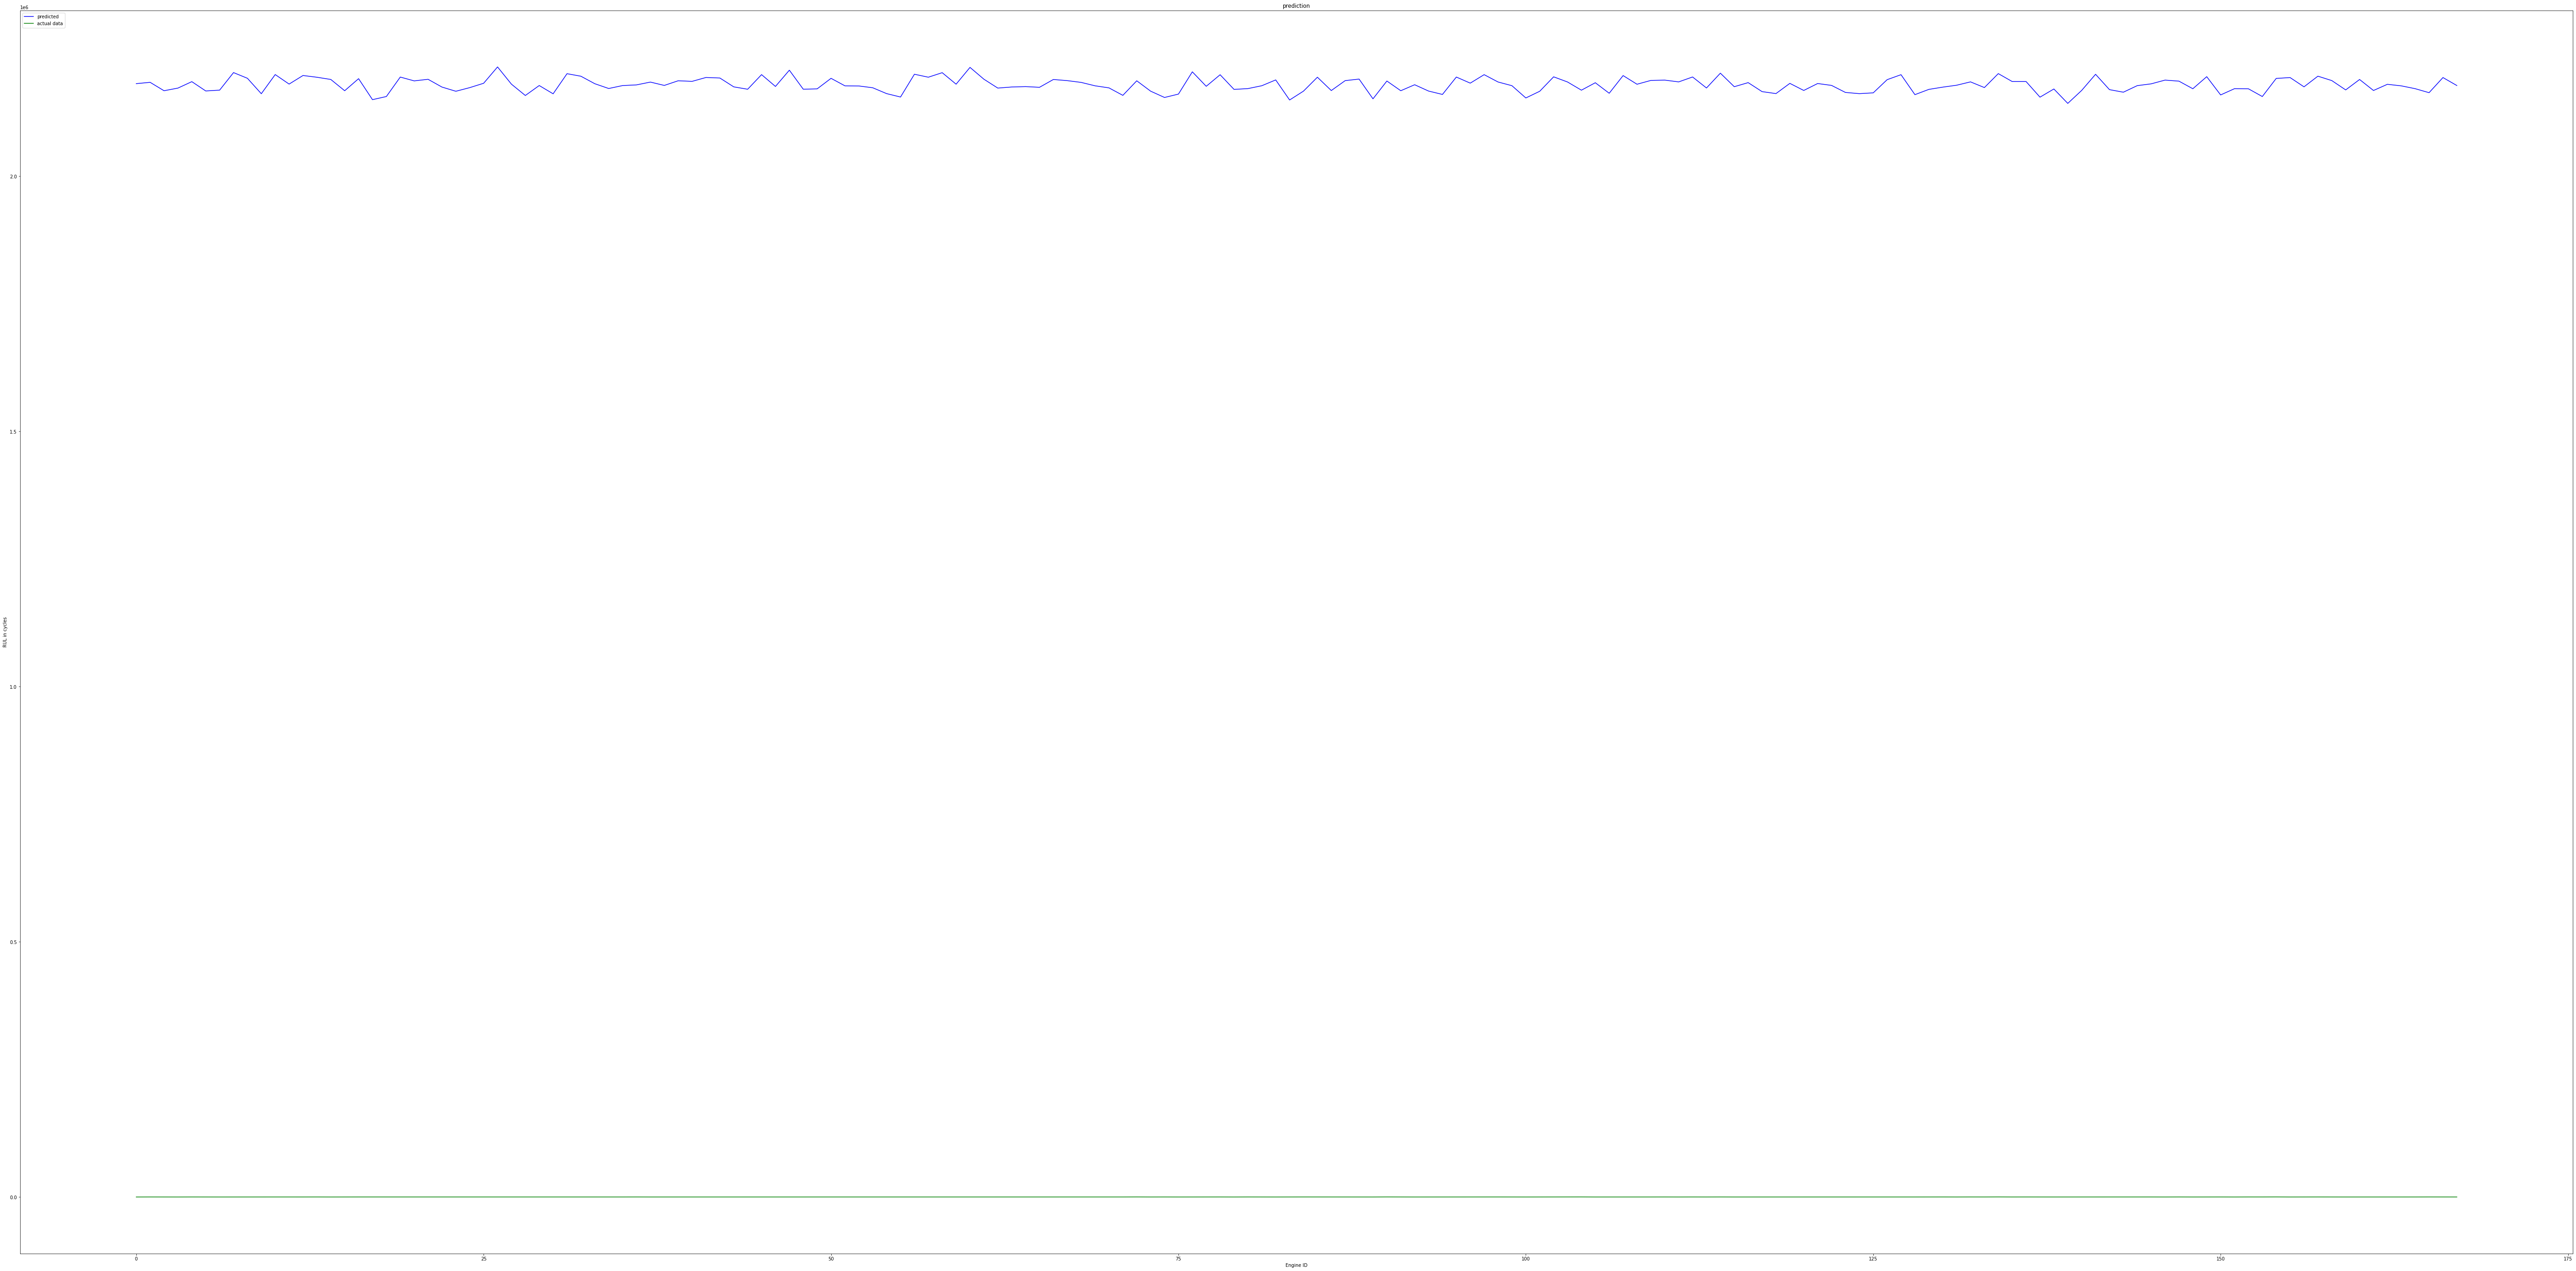

In [51]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('RUL in cycles')
plt.xlabel('Engine ID')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify_combo1.png")
